# **Stroke Dataset: Comparing LogisticRegression, RandomForest and CNN**

## **Introduction**
A stroke, sometimes called a brain attack, occurs when something blocks blood supply to part of the brain or when a blood vessel in the brain bursts. In either case, parts of the brain become damaged or die. A stroke can cause lasting brain damage, long-term disability, or even death. According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. Our objective is to understand what are the reasons that cause stroke to peoeple and see if we can succefully detect stroke on some features using LogisticRegression, RandomForest and CNN.

### Import libraries and dataset

In [114]:
!pip install shap h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [115]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import statsmodels.api as sm
from sklearn import metrics
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil

### **First Look of Data**

In [116]:
#Reading the HeartAttack data
df=pd.read_csv("/content/drive/MyDrive/full_data.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [118]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [119]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


### **Exploratory data analasis(EDA)**

#### **Stroke numbers in dataset**

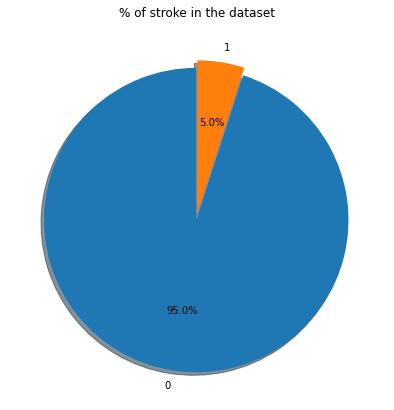

In [120]:
labels =df['stroke'].value_counts(sort = True).index
sizes = df['stroke'].value_counts(sort = True)
explode = (0.05,0) 
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90,)
plt.title('% of stroke in the dataset')
plt.show()

From above pie chart, we have really less peoples who suffered stroke. But, this also means that our dataset is imbalance. We likely have to use sampling techniques to make the data balance.
#### **Distribution of continuous variables**

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 0, 'average glucose level in blood')

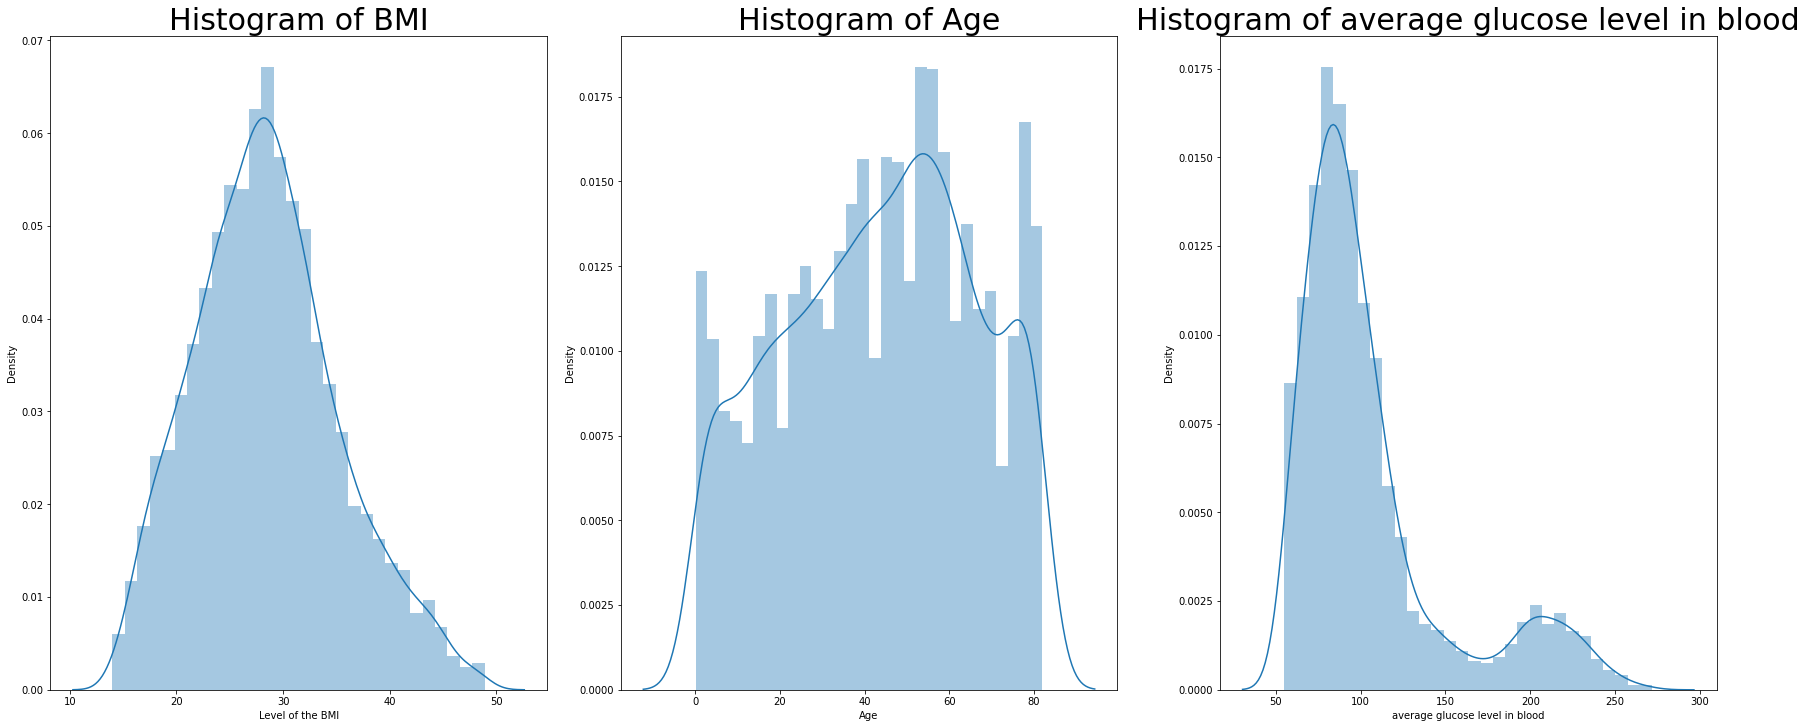

In [121]:
fig, axes = plt.subplots(1,3,figsize=(25,10),constrained_layout=True)
sns.distplot(df.bmi, bins=30,ax=axes[0])
axes[0].set_title(f'Histogram of BMI',fontsize=30)
axes[0].set_xlabel("Level of the BMI")
sns.distplot(df.age, bins=30,ax=axes[1])
axes[1].set_title(f'Histogram of Age',fontsize=30)
axes[1].set_xlabel("Age")
sns.distplot(df.avg_glucose_level, bins=30,ax=axes[2])
axes[2].set_title(f'Histogram of average glucose level in blood',fontsize=30)
axes[2].set_xlabel("average glucose level in blood")

#### **Categorical variables**

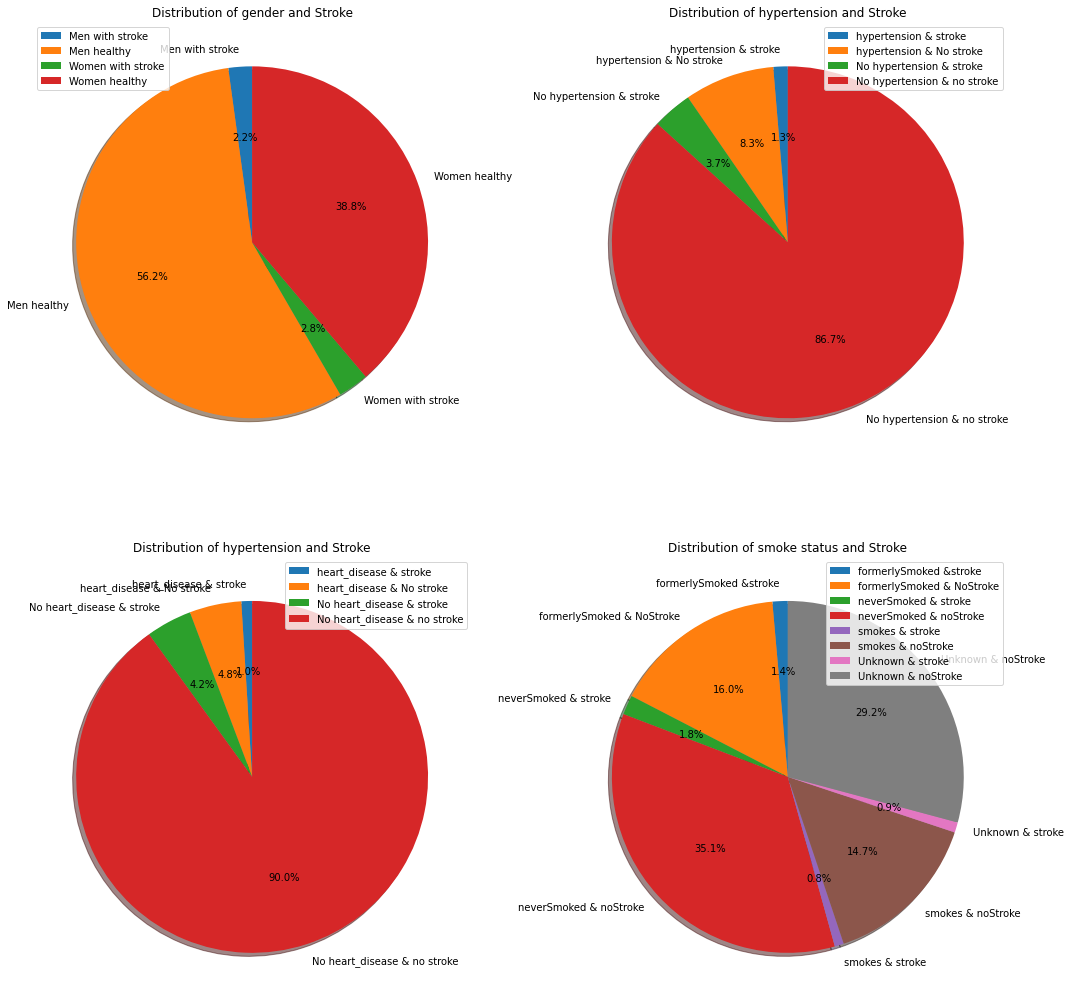

In [122]:
#gender & stroke
len_data = len(df)
len_w = len(df[df["gender"]=="Male"])
len_m = len_data - len_w
men_stroke = len(df.loc[(df["stroke"]==1)&(df['gender']=="Male")])
men_no_stroke = len_m - men_stroke
women_stroke = len(df.loc[(df["stroke"]==1) & (df['gender']=="Female")])
women_no_stroke = len_w - women_stroke
labels = ['Men with stroke','Men healthy','Women with stroke','Women healthy']
values = [men_stroke, men_no_stroke, women_stroke, women_no_stroke]
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Distribution of gender and Stroke")
plt.pie(values,labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend()
#hypertension & stroke
len_h = len(df[df["hypertension"]==1])
len_nh = len_data - len_h
hy_stroke = len(df.loc[(df["stroke"]==1)&(df['hypertension']==1)])
hy_no_stroke = len_h - hy_stroke
nhy_stroke = len(df.loc[(df["stroke"]==1) & (df['hypertension']==0)])
nhy_no_stroke = len_nh - nhy_stroke
labels1 = ['hypertension & stroke','hypertension & No stroke','No hypertension & stroke','No hypertension & no stroke']
values1 = [hy_stroke, hy_no_stroke, nhy_stroke, nhy_no_stroke]
plt.subplot(2,2,2)
plt.title("Distribution of hypertension and Stroke")
plt.pie(values1,labels=labels1, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend()
#heart_disease & stroke
len_hd = len(df[df["heart_disease"]==1])
len_nhd = len_data - len_h
hd_stroke = len(df.loc[(df["stroke"]==1)&(df['heart_disease']==1)])
hd_no_stroke = len_hd - hd_stroke
nhd_stroke = len(df.loc[(df["stroke"]==1) & (df['heart_disease']==0)])
nhd_no_stroke = len_nhd - nhd_stroke
labels2 = ['heart_disease & stroke','heart_disease & No stroke','No heart_disease & stroke','No heart_disease & no stroke']
values2 = [hd_stroke, hd_no_stroke, nhd_stroke, nhd_no_stroke]
plt.subplot(2,2,3)
plt.title("Distribution of hypertension and Stroke")
plt.pie(values2,labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend()
#smoking_status & stroke
len_fs = len(df[df["smoking_status"]=="formerly smoked"])
len_ns = len(df[df["smoking_status"]=="never smoked"])
len_smokes = len(df[df["smoking_status"]=="smokes"])
len_unknow=len_data - len_fs-len_ns-len_smokes
fs_stroke = len(df.loc[(df["stroke"]==1)&(df['smoking_status']=="formerly smoked")])
fs_no_stroke = len_fs - fs_stroke
ns_stroke = len(df.loc[(df["stroke"]==1) & (df['smoking_status']=="never smoked")])
ns_no_stroke = len_ns - ns_stroke
smokes_stroke = len(df.loc[(df["stroke"]==1) & (df['smoking_status']=="smokes")])
smokes_no_stroke = len_smokes - smokes_stroke
unknow_stroke = len(df.loc[(df["stroke"]==1) & (df['smoking_status']=="Unknown")])
unknow_no_stroke = len_unknow - unknow_stroke
labels3 = ['formerlySmoked &stroke','formerlySmoked & NoStroke','neverSmoked & stroke','neverSmoked & noStroke','smokes & stroke','smokes & noStroke','Unknown & stroke','Unknown & noStroke']
values3 = [fs_stroke, fs_no_stroke, ns_stroke, ns_no_stroke,smokes_stroke,smokes_no_stroke,unknow_stroke,unknow_no_stroke]
plt.subplot(2,2,4)
plt.title("Distribution of smoke status and Stroke")
plt.pie(values3,labels=labels3, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend()
plt.tight_layout()
plt.show()

Surprisingly, it seems that the stroke is not highly corralated to smokers since the proportion of person having a stroke is fairly the same among the different smoking status.

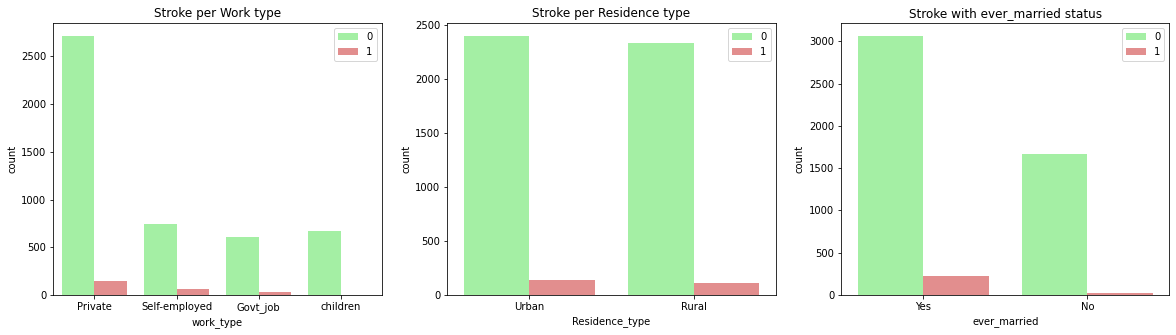

In [123]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
#Stroke/Work_type
sns.countplot(x='work_type', hue='stroke', data=df,palette=["palegreen","lightcoral"])
plt.title("Stroke per Work type")
plt.legend()
plt.subplot(1,3,2)
#Stroke/Residence_type
sns.countplot(x='Residence_type', hue='stroke', data=df,palette=["palegreen","lightcoral"])
plt.title("Stroke per Residence type")
plt.legend()
plt.subplot(1,3,3)
#Stroke/ever_married
sns.countplot(x='ever_married', hue='stroke', data=df,palette=["palegreen","lightcoral"])
plt.title("Stroke with ever_married status")
plt.legend()
plt.show()

#### **Checking variavbles ranges and outliers**

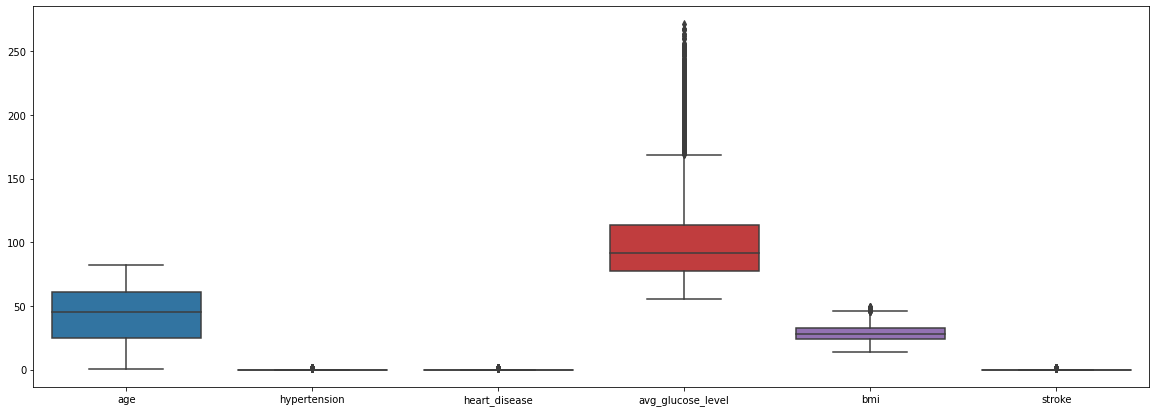

In [125]:
#Checking the Ranges of the predictor variables and dependent variable
plt.figure(figsize=(20,7))
sns.boxplot(data=df)

### **Data processing & Feature selection**
#### **Removing outliers**

In [126]:
cat_cols = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']
cont_cols=['age','avg_glucose_level','bmi']

def treat_outlier(x):
    sorted(x)
    q1,q3=np.percentile(x,[25,75])
    iqr=q3-q1
    l_r=q1-(1.5*iqr)
    u_r=q3+(1.5*iqr)
    return l_r,u_r  

for i in df[cont_cols].columns:
    lr,ur = treat_outlier(df[i])
    df[i] = np.where(df[i]>ur,ur,df[i])
    df[i] = np.where(df[i]<lr,lr,df[i])


#### **Scaling**

In [127]:

#convering categorical features to numerical
df['gender'] = df['gender'].map({'Male':int(1),'Female':int(0)})
df['ever_married'] = df['ever_married'].map({'Yes':int(1),'No':int(0)})
df = pd.get_dummies(df,columns=['work_type','smoking_status'],drop_first=False)
df = pd.get_dummies(df,columns=['Residence_type'],drop_first=True)
y=df["stroke"]
X = df.drop(columns=["stroke"])
print(sum(y==1))
print(sum(y==0))


248
4733


In [128]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
# scaling the continuous featuree
X[cont_cols] = sc.fit_transform(X[cont_cols])


#### **Data Imbalance processed with SMOTE**

In [224]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X, y = sm.fit_resample(X,y.ravel())

#### **Split data to train and test set**

In [225]:
#split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


#### **Feature Imprtance**

#### **Correlation**

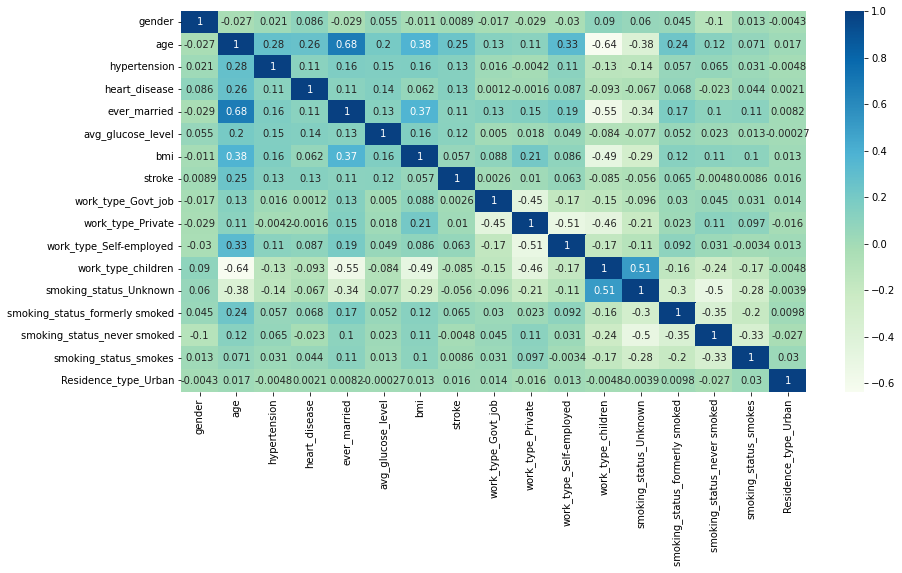

In [176]:
#the heat map of the correlation
correlation = df.corr()
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap = 'GnBu')

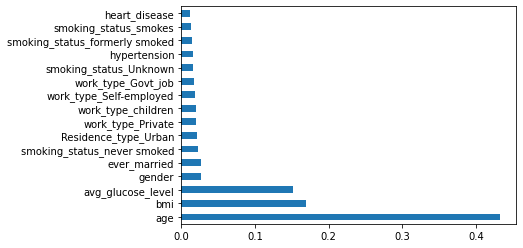

,0
gender,0.026925
age,0.432880
hypertension,0.015656
heart_disease,0.012121
ever_married,0.026273
avg_glucose_level,0.151582
bmi,0.169705
work_type_Govt_job,0.017681
work_type_Private,0.020304
work_type_Self-employed,0.018688


In [209]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
# define the model
model = RandomForestClassifier()
# Train the model using the training sets
model.fit(X,y)

# Make predictions using the training set
y_pred = model.predict(X)
# get importance
importance = model.feature_importances_
# summarize feature importance
feat_importances = pd.Series(importance, index=X.columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()
feature_importances = pd.DataFrame(importance,X.columns)
feature_importances

From the feature importance plot, we can find that smoking_status_smokes and hypertension is less important than other variables, so we try drop them from data and observe how model will be affected.

## **Model training**
In this notebook, i trained logistic regression, random forest and cnn model to observe their performance in this stroke dataset.
### **Linear model: Logistic regression**
In statistics, the logistic model (or logit model) is a statistical model that models the probability of an event taking place by having the log-odds for the event be a linear combination of one or more independent variables. Logistic regression models the probabilities for classification problems with two possible outcomes. It’s an extension of the linear regression model for classification problems.

The logistic Regression model's accuracy scoreis 82.576558 %.
ROC AUC Score: 0.83


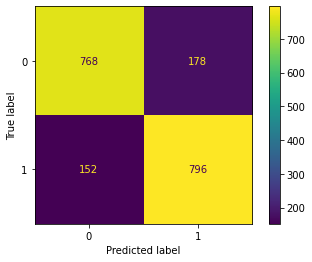

In [227]:
#Create Logistic regression object
logit = LogisticRegression(random_state= 0)
# Train the model using the training sets without feature selection
logit.fit(X_train, y_train)
# Make predictions using the testing set
logit_pred = logit.predict(X_test)

print("The logistic Regression model's accuracy scoreis {} %.".format(round(metrics.accuracy_score(y_test, logit_pred)*100,6)))
roc = roc_auc_score(y_test, logit_pred)
print('ROC AUC Score: {:.2f}'.format(roc))
ConfusionMatrixDisplay.from_predictions(y_test, logit_pred)


### **Random Forest**
Random forest is a commonly-used machine learning algorithm trademarked by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems.The random forest algorithm is an extension of the bagging method as it utilizes both bagging and feature randomness to create an uncorrelated forest of decision trees.

The random forest model's accuracy scoreis 88.331573 %.
ROC AUC Score: 0.88


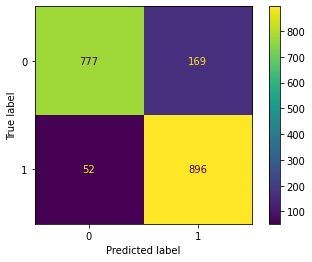

In [228]:
# define the model
ranf = RandomForestClassifier(max_depth=9,random_state=42)
# Train the model using the training sets
ranf.fit(X_train,y_train)

# Make predictions using the training set
rforest_pred = ranf.predict(X_test)

print("The random forest model's accuracy scoreis {} %.".format(round(metrics.accuracy_score(y_test, rforest_pred)*100,6)))
roc1 = roc_auc_score(y_test, rforest_pred)
print('ROC AUC Score: {:.2f}'.format(roc1))
ConfusionMatrixDisplay.from_predictions(y_test, rforest_pred)

### **Convolutional Neural Network(CNN)**
Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and are at the heart of deep learning algorithms. 
<img src="https://miro.medium.com/max/1400/1*vkQ0hXDaQv57sALXAJquxA.webp"/>
A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm that can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

Convolutional neural networks are distinguished from other neural networks by their superior performance with image, speech, or audio signal inputs. They have three main types of layers, which are:
- Convolutional layer
- Pooling layer
- Fully-connected (FC) layer

The convolutional layer is the first layer of a convolutional network. While convolutional layers can be followed by additional convolutional layers or pooling layers, the fully-connected layer is the final layer. With each layer, the CNN increases in its complexity, identifying greater portions of the image. Earlier layers focus on simple features, such as colors and edges. As the image data progresses through the layers of the CNN, it starts to recognize larger elements or shapes of the object until it finally identifies the intended object. Here we applied CNN in this stroke dataset and observe how it accurate the prediction.

In [261]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *

cnnmodel = Sequential()
#add convlutional1D layer with 32 filters
cnnmodel.add(Conv1D(32,2,activation='relu',input_shape=(16,1)))
#pool layer
cnnmodel.add(MaxPooling1D(2, strides=2))
#add convlutional1D layer with 128 filters
cnnmodel.add(Conv1D(64,2, activation='relu'))
cnnmodel.add(MaxPooling1D(2, strides=2))
#enter fully connected layer
cnnmodel.add(Flatten())
cnnmodel.add(Dense(32, activation='relu'))
cnnmodel.add(Dense(1, activation='sigmoid'))
#using binary_crossentropy for our stroke or not prediction
opt = Adam()
cnnmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
cnnmodel.summary()
history = cnnmodel.fit(X_train, y_train, epochs = 30, validation_data=(X_test, y_test), verbose=1)


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_46 (Conv1D)          (None, 15, 32)            96        
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 7, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_47 (Conv1D)          (None, 6, 64)             4160      
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 192)               0         
                                                                 
 dense_50 (Dense)            (None, 32)              

60/60 [==============================] - 0s 2ms/step
The CNN model's accuracy scoreis 88.12038 %.
ROC AUC Score: 0.88


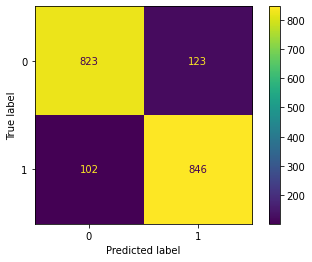

In [280]:
cnn_predictions = (cnnmodel.predict(X_test) > 0.5).astype("int32")
print("The CNN model's accuracy scoreis {} %.".format(round(accuracy_score(y_test, cnn_predictions)*100,6)))
print('ROC AUC Score: {:.2f}'.format(roc_auc_score(y_test, cnn_predictions)))
ConfusionMatrixDisplay.from_predictions(y_test, cnn_predictions)

### **Random Forest with Hyperparameter tuning**
Random Forest Hyperparameters we’ll be Looking at:
- max_depth
- min_sample_split
- min_samples_leaf
- n_estimators
- max_features

In [259]:
n_estimators = [5,20,50,100] # number of trees in the forest
max_features = ['auto', 'sqrt','log2'] # maximum number of features in an individual tree
max_depth = [6,10,16,22,28] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum number of samples required to split an internal node
min_samples_leaf = [1, 3, 4] # minimum number of samples required to be at a leaf node

random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier()
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train, y_train)
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 28}  



The random forest model's accuracy scoreis 94.350581 %.
ROC AUC Score: 0.94


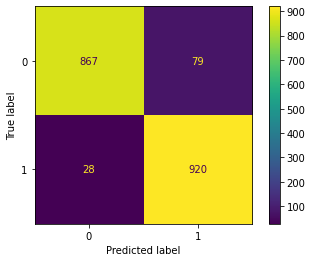

In [260]:
# define the model
ranf1 = RandomForestClassifier(n_estimators=50,min_samples_split=2,min_samples_leaf=1,max_features='log2',max_depth=28,random_state=42)
# Train the model using the training sets
ranf1.fit(X_train,y_train)

# Make predictions using the training set
rforest_pred1 = ranf1.predict(X_test)

print("The random forest model's accuracy scoreis {} %.".format(round(metrics.accuracy_score(y_test, rforest_pred1)*100,6)))
roc1 = roc_auc_score(y_test, rforest_pred1)
print('ROC AUC Score: {:.2f}'.format(roc1))
ConfusionMatrixDisplay.from_predictions(y_test, rforest_pred1)

After tuning hyperparameter with random forest, we find the model with {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 28} has higher accuracy and ROC AUC score, which is outperform the baseline random forest model.

### **CNN with architecture and parameters adjustment**

In CNN model, i will add some layers and adjust gradient estimation to see how they affect result.

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_138 (Conv1D)         (None, 15, 32)            96        
                                                                 
 max_pooling1d_127 (MaxPooli  (None, 7, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_139 (Conv1D)         (None, 6, 64)             4160      
                                                                 
 max_pooling1d_128 (MaxPooli  (None, 3, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_59 (Flatten)        (None, 192)               0         
                                                                 
 dense_195 (Dense)           (None, 128)             

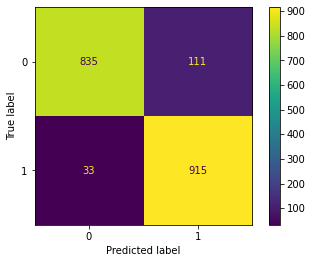

In [304]:
cnnmodel1 = Sequential()
#add convlutional1D layer with 32 filters
cnnmodel1.add(Conv1D(32,2,activation='relu',input_shape=(16,1)))
#pool layer
cnnmodel1.add(MaxPooling1D(2, strides=2))
#add convlutional1D layer with 128 filters
cnnmodel1.add(Conv1D(64,2, activation='relu'))
cnnmodel1.add(MaxPooling1D(2, strides=2))
#enter fully connected layer
cnnmodel1.add(Flatten())
cnnmodel1.add(Dense(128, activation='relu'))
cnnmodel1.add(Dense(64, activation='relu'))
cnnmodel1.add(Dense(32, activation='relu'))
cnnmodel1.add(Dense(1, activation='sigmoid'))
#using binary_crossentropy for our stroke or not prediction
opt = Adam()
cnnmodel1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
cnnmodel1.summary()
history1 = cnnmodel1.fit(X_train, y_train, epochs = 30, validation_data=(X_test, y_test), verbose=0)
cnn_predictions1 = (cnnmodel1.predict(X_test) > 0.5).astype("int32")
print("The CNN model's accuracy scoreis {} %.".format(round(accuracy_score(y_test, cnn_predictions1)*100,6)))
print('ROC AUC Score: {:.2f}'.format(roc_auc_score(y_test, cnn_predictions1)))
ConfusionMatrixDisplay.from_predictions(y_test, cnn_predictions1)

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_146 (Conv1D)         (None, 15, 32)            96        
                                                                 
 max_pooling1d_135 (MaxPooli  (None, 7, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_147 (Conv1D)         (None, 6, 64)             4160      
                                                                 
 max_pooling1d_136 (MaxPooli  (None, 3, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_63 (Flatten)        (None, 192)               0         
                                                                 
 dense_207 (Dense)           (None, 32)              

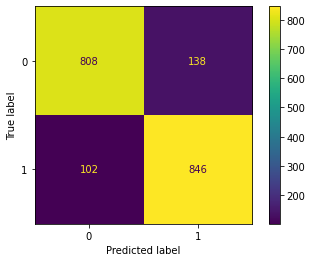

In [308]:
cnnmodel2 = Sequential()
#add convlutional1D layer with 32 filters
cnnmodel2.add(Conv1D(32,2,activation='relu',input_shape=(16,1)))
#pool layer
cnnmodel2.add(MaxPooling1D(2, strides=2))
#add convlutional1D layer with 128 filters
cnnmodel2.add(Conv1D(64,2, activation='relu'))
cnnmodel2.add(MaxPooling1D(2, strides=2))
#enter fully connected layer
cnnmodel2.add(Flatten())
cnnmodel2.add(Dense(32, activation='relu'))
cnnmodel2.add(Dense(1, activation='sigmoid'))
#using binary_crossentropy for our stroke or not prediction
opt = RMSprop()
cnnmodel2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
cnnmodel2.summary()
history2 = cnnmodel2.fit(X_train, y_train, epochs = 30, validation_data=(X_test, y_test), verbose=0)
cnn_predictions2 = (cnnmodel2.predict(X_test) > 0.5).astype("int32")
print("The CNN model's accuracy scoreis {} %.".format(round(accuracy_score(y_test, cnn_predictions2)*100,6)))
print('ROC AUC Score: {:.2f}'.format(roc_auc_score(y_test, cnn_predictions2)))
ConfusionMatrixDisplay.from_predictions(y_test, cnn_predictions2)

We can find that add 2 dense layers with 128 unit and 64 units will make cnn model perform better than baseline cnn model in this stroke dataset. And i try to use RMSprop as gradient estimation will not make model perform better than one with Adam optimizer.

### Model Interpretation with SHAP

In [ ]:
#create explainer to calculate shap values for random forest model
rfExplainer = shap.TreeExplainer(ranf,X_train)
rf_shap_values = rfExplainer.shap_values(X_test,check_additivity=False)
shap.initjs()
#shap.force_plot(rfExplainer.expected_value[0], rf_shap_values[0], X_test)#choose and show a single prediction

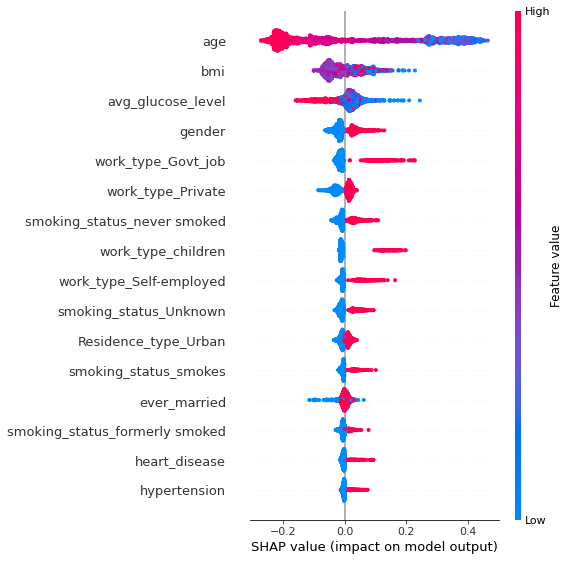

In [310]:
shap.summary_plot(rf_shap_values[0], X_test)

From this shap summary plot,we can not only observe the feature importance but also their effect direction on shap values.<br/>
In general, 'age' is most important among these features and lower value lead more probability to not having heart attack. 
Followed with 'bmi' and 'worktype_self_employee', the 'avg_glucose_level' is low then lower probability patient have heart attack.
And observe the distribution of 'age', instance of lower age extend further towards the right, suggesting low age has stronger positive impact to make a not having  stroke prediction than the negative impact of higher age. <br/>
Check the bottom instance distribution of 'hypertension', it has almost no influence upon shap output.

### Conclusion
In this stroke prediction dataset, we can find from EDA and shap plot that age is most important feature which people with higher age may has more odds to have a stroke than one has lower age.

And observe the result of training logistic regression, random forest and CNN model, a random forest model with hyperparamters value be ('n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 28) can have a test accuracy reached about 94% and a ROC AUC score be 0.94. In addition, the test accuracy of a CNN model with 2 conv1d layers, 2 maxpool layers and 4 dense layers is 92% and its ROC AUC score is 0.92.

In general, a random forest with hyperparamters value be ('n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 28) is the best model for this dataset among our experiment models.
### Reference
[1]https://www.kaggle.com/code/gaetanlopez/how-to-make-clean-visualizations/data <br/>
[2]https://www.kaggle.com/code/dansbecker/shap-values <br/>
[3]https://shap.readthedocs.io/en/latest/ <br/>
[4]https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb<br/>
[5]https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53<br/>
[6]https://keras.io/api/layers/convolution_layers/<br/>
codes refer to [2],[3] and [6], modified parameters for experiments.

### Liciense
Copyright 2022 Yanping Fu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.